# Resume Screening with Python

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import warnings
import string
import nltk
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Define a function to preprocess text data
def preprocess_text(text):
    # Remove special characters and symbols
    processed_text = re.sub(r'[^\w\s]', '', text)
    return processed_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Load the CSV file into a DataFrame
resumeDataSet = pd.read_csv('UpdatedResumeDataSet.csv', encoding='utf-8')

# Create a new column for cleaned resumes (initialized with empty strings)
resumeDataSet['cleaned_resume'] = ''

# Display the first few rows of the DataFrame to verify the changes
resumeDataSet.head()

,Category,Resume,cleaned_resume
0,Data Science,Skills * Programming Languages: Python (pandas...,
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",


In [3]:
print ("Displaying the distinct categories of resume -")
print (resumeDataSet['Category'].unique())

Displaying the distinct categories of resume -
['Data Science' 'HR' 'Advocate' 'Arts' 'Web Designing'
 'Mechanical Engineer' 'Sales' 'Health and fitness' 'Civil Engineer'
 'Java Developer' 'Business Analyst' 'SAP Developer' 'Automation Testing'
 'Electrical Engineering' 'Operations Manager' 'Python Developer'
 'DevOps Engineer' 'Network Security Engineer' 'PMO' 'Database' 'Hadoop'
 'ETL Developer' 'DotNet Developer' 'Blockchain' 'Testing']


In [4]:
print ("Displaying the distinct categories of resume and the number of records belonging to each category -")
print (resumeDataSet['Category'].value_counts())

Displaying the distinct categories of resume and the number of records belonging to each category -
Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: count, dtype: int64


## Visualize the number of categories in the dataset

<Axes: xlabel='count', ylabel='Category'>

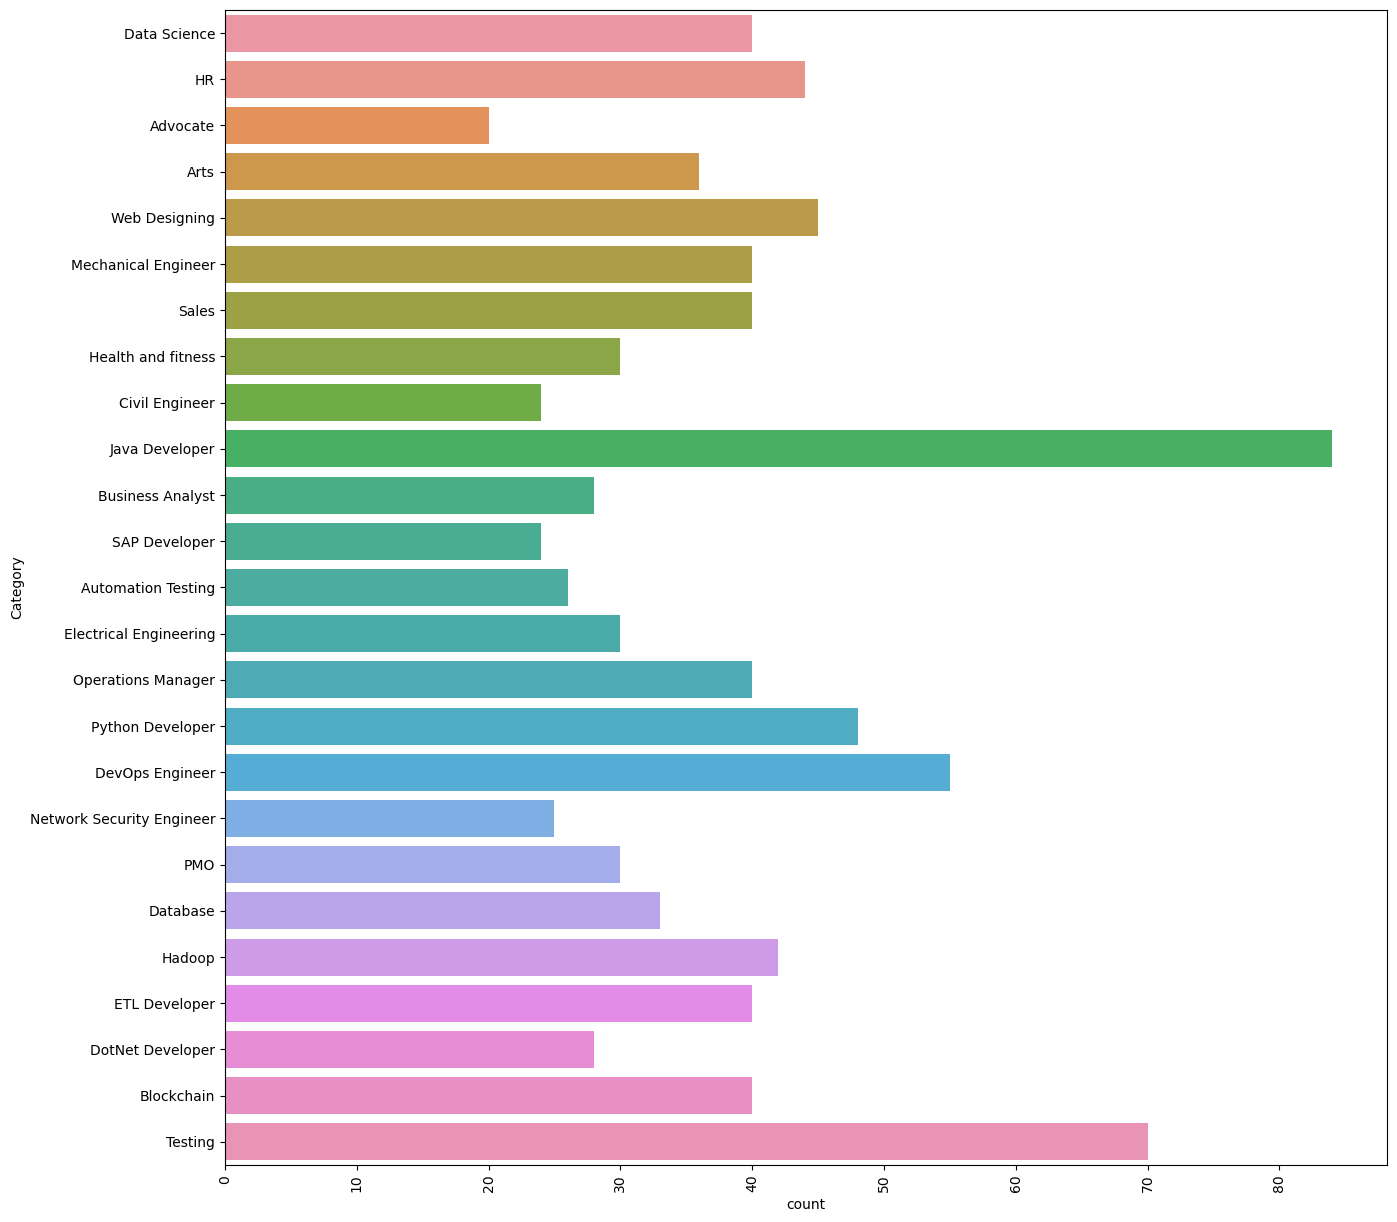

In [5]:
plt.figure(figsize=(15,15))
plt.xticks(rotation=90)
sns.countplot(y="Category", data=resumeDataSet)

## Visualize the distribution of categories

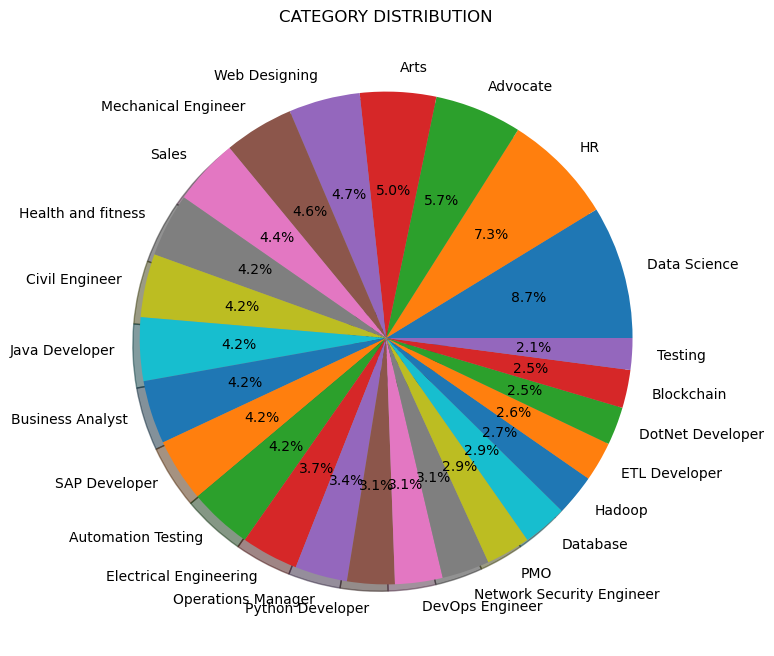

In [6]:
# Get category counts and unique labels
targetCounts = resumeDataSet['Category'].value_counts()
targetLabels = resumeDataSet['Category'].unique()

# Set up figure and grid
plt.figure(figsize=(10, 8))
the_grid = GridSpec(1, 1)

# Create pie chart for category distribution
plt.subplot(the_grid[0, 0], aspect=1, title='CATEGORY DISTRIBUTION')
plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True)

# Show the plot
plt.show()

In [7]:
def cleanResume(resumeText):
    # Remove URLs
    resumeText = re.sub('http\S+\s*', ' ', resumeText)
    # Remove RT and cc
    resumeText = re.sub('RT|cc', ' ', resumeText)
    # Remove hashtags
    resumeText = re.sub('#\S+', '', resumeText)
    # Remove mentions
    resumeText = re.sub('@\S+', ' ', resumeText)
    # Remove punctuations
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)
    # Remove non-ASCII characters
    resumeText = re.sub(r'[^\x00-\x7f]', ' ', resumeText)
    # Remove extra whitespaces
    resumeText = re.sub('\s+', ' ', resumeText)
    return resumeText

# Apply the cleanResume function to the 'Resume' column and store the cleaned text in a new column
resumeDataSet['cleaned_resume'] = resumeDataSet['Resume'].apply(cleanResume)

[('Details', 484), ('Exprience', 446), ('months', 376), ('company', 330), ('description', 310), ('1', 290), ('year', 232), ('January', 216), ('Less', 204), ('Data', 200), ('data', 192), ('Skill', 166), ('Maharashtra', 166), ('6', 164), ('Python', 156), ('Science', 154), ('I', 146), ('Education', 142), ('College', 140), ('The', 126), ('project', 126), ('like', 126), ('Project', 124), ('Learning', 116), ('India', 114), ('Machine', 112), ('University', 112), ('Web', 106), ('using', 104), ('monthsCompany', 102), ('B', 98), ('C', 98), ('SQL', 96), ('time', 92), ('learning', 90), ('Mumbai', 90), ('Pune', 90), ('Arts', 90), ('A', 84), ('application', 84), ('Engineering', 78), ('24', 76), ('various', 76), ('Software', 76), ('Responsibilities', 76), ('Nagpur', 76), ('development', 74), ('Management', 74), ('projects', 74), ('Technologies', 72)]


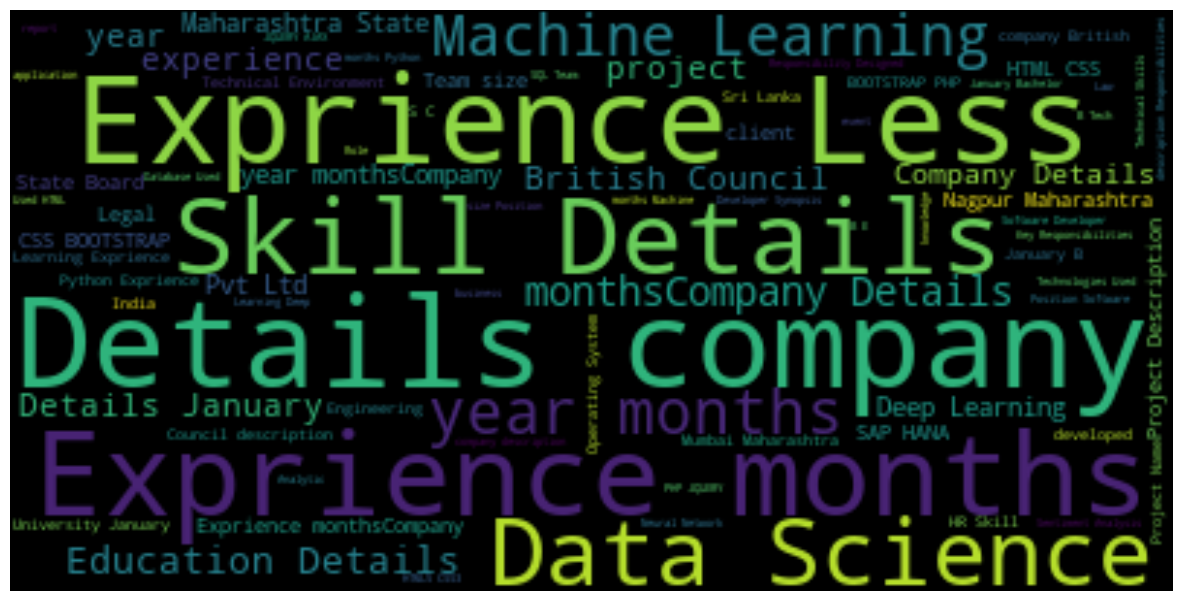

In [8]:
# Define a set of stopwords for English, including additional custom stopwords
oneSetOfStopWords = set(stopwords.words('english') + ['``', "''"])

# Initialize lists to store words and cleaned sentences
totalWords = []
cleanedSentences = ""

# Iterate through a subset of resumes
for i in range(160):
    # Clean each resume text
    cleanedText = cleanResume(resumeDataSet['Resume'][i])
    # Concatenate cleaned text into a single string
    cleanedSentences += cleanedText
    # Tokenize cleaned text
    requiredWords = nltk.word_tokenize(cleanedText)
    # Filter out stopwords and punctuation
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)

# Calculate word frequency distribution
wordfreqdist = nltk.FreqDist(totalWords)
# Find the 50 most common words
mostcommon = wordfreqdist.most_common(50)
print(mostcommon)

# Generate a word cloud visualization
wc = WordCloud().generate(cleanedSentences)
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show();

In [9]:
# Define the categorical variables to be encoded
var_mod = ['Category']

# Initialize a LabelEncoder
le = LabelEncoder()

# Iterate through each categorical variable
for i in var_mod:
    # Fit and transform the variable using LabelEncoder and update the DataFrame
    resumeDataSet[i] = le.fit_transform(resumeDataSet[i])

In [10]:
# Extract text data and target labels
requiredText = resumeDataSet['cleaned_resume'].values
requiredTarget = resumeDataSet['Category'].values

# Initialize a TF-IDF vectorizer
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,  # Apply sublinear TF scaling
    stop_words='english',  # Exclude common English stopwords
    max_features=1500  # Limit the maximum number of features to 1500
)

# Fit the vectorizer to the text data and transform it into a TF-IDF matrix
word_vectorizer.fit(requiredText)
WordFeatures = word_vectorizer.transform(requiredText)

print("Feature extraction completed...")

Feature extraction completed...


In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(WordFeatures, requiredTarget, random_state=0, test_size=0.2)

# Print the shapes of the training and testing sets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (769, 1500)
Testing set shape: (193, 1500)


In [12]:
# Initialize a One-vs-Rest classifier with KNeighborsClassifier as the base estimator
clf = OneVsRestClassifier(KNeighborsClassifier())

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the testing data
prediction = clf.predict(X_test)

# Print the accuracy of the classifier on the training and testing sets
print('Accuracy of KNeighbors Classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of KNeighbors Classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of KNeighbors Classifier on training set: 0.99
Accuracy of KNeighbors Classifier on test set: 0.99


In [13]:
# Print the classification report
print("\nClassification report for classifier %s:\n%s\n" % (clf, metrics.classification_report(y_test, prediction)))


Classification report for classifier OneVsRestClassifier(estimator=KNeighborsClassifier()):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         6
           5       0.83      1.00      0.91         5
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         7
           8       1.00      0.91      0.95        11
           9       1.00      1.00      1.00         9
          10       1.00      1.00      1.00         8
          11       0.90      1.00      0.95         9
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         9
          14       1.00      1.00      1.00         7
          15       1.00      1.00      1.0